In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage7",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8702 files belonging to 5 classes.


In [4]:
class_names=dataset.class_names
class_names

['anthracnose', 'die_black', 'gall_midge', 'healthy', 'powdery_mildew']

In [5]:
len(dataset)

272

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 3 3 3 3 2 0 3 3 1 2 1 3 2 3 3 0 0 1 4 2 1 2 1 2 2 0 2 1 0 2 4]


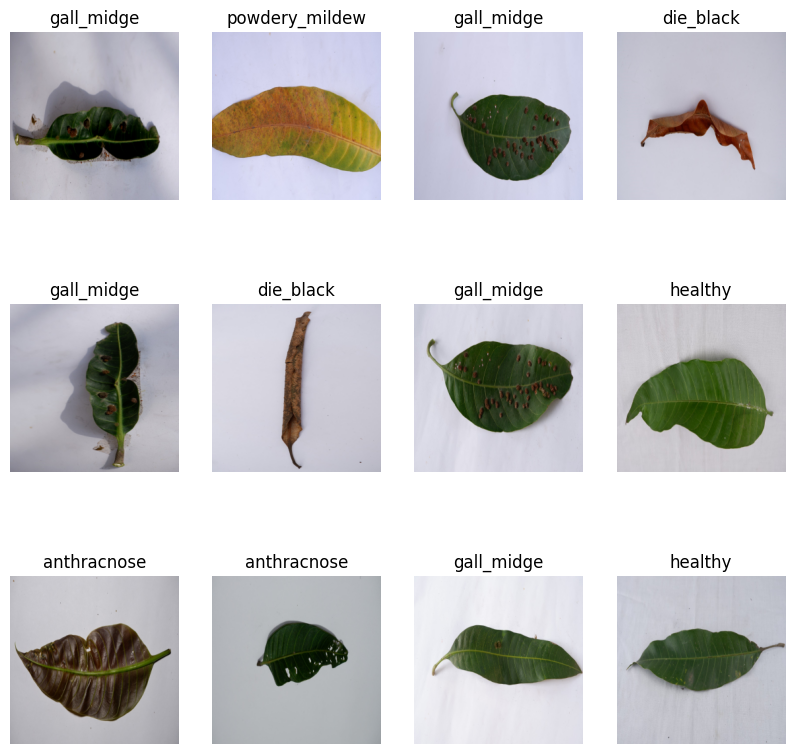

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [8]:
train_size=0.8
train_ds=dataset.take(217)


In [9]:
test_ds=dataset.skip(217)

In [10]:
len(test_ds)

55

In [11]:
val_size=0.1
val_ds=test_ds.take(27)


In [12]:
test_ds=test_ds.skip(27)

In [13]:
def get_dataset_partions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
        
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds, val_ds, test_ds
    

In [14]:
train_ds, val_ds, test_ds=get_dataset_partions_tf(dataset)

In [15]:
len(train_ds)

217

In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [18]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [19]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes=5
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [22]:
EPOCHS=30
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/30
217/217 [==============================] - 64s 237ms/step - loss: 0.9686 - accuracy: 0.5919 - val_loss: 0.5140 - val_accuracy: 0.8021
Epoch 2/30
217/217 [==============================] - 45s 207ms/step - loss: 0.4941 - accuracy: 0.8088 - val_loss: 0.4144 - val_accuracy: 0.8275
Epoch 3/30
217/217 [==============================] - 44s 204ms/step - loss: 0.3212 - accuracy: 0.8813 - val_loss: 0.5749 - val_accuracy: 0.7917
Epoch 4/30
217/217 [==============================] - 45s 205ms/step - loss: 0.2162 - accuracy: 0.9237 - val_loss: 0.2715 - val_accuracy: 0.9097
Epoch 5/30
217/217 [==============================] - 45s 207ms/step - loss: 0.1290 - accuracy: 0.9525 - val_loss: 0.1116 - val_accuracy: 0.9653
Epoch 6/30
217/217 [==============================] - 45s 206ms/step - loss: 0.1276 - accuracy: 0.9545 - val_loss: 0.1037 - val_accuracy: 0.9583
Epoch 7/30
217/217 [==============================] - 44s 203ms/step - loss: 0.0862 - accuracy: 0.9703 - val_loss: 0.2247 - val_ac

In [23]:
model.evaluate(test_ds)

28/28 [==============================] - 6s 28ms/step - loss: 0.0389 - accuracy: 0.9855


[0.038927171379327774, 0.9854910969734192]

In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

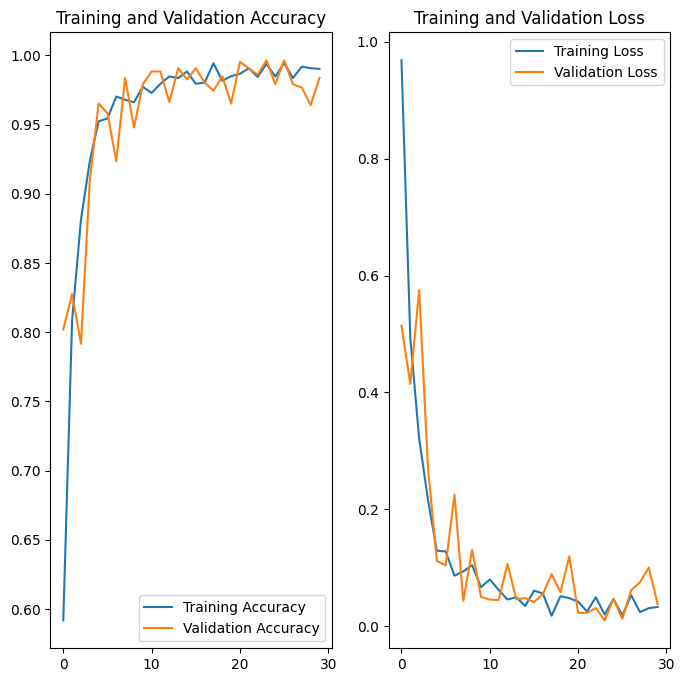

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first  image to predict
image's actual label: die_black
1/1 [==============================] - 0s 196ms/step
die_black


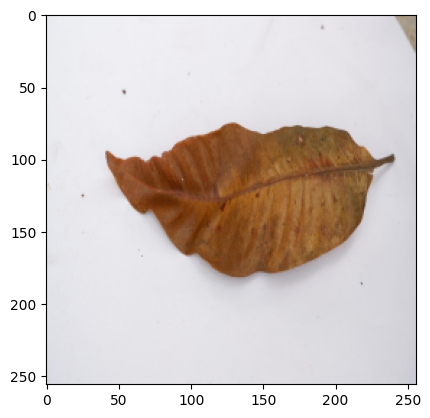

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[1].numpy().astype('uint8')
    first_label=labels_batch[1].numpy()
    print("first  image to predict")
    plt.imshow(first_image)
    print("image's actual label:",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[1])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


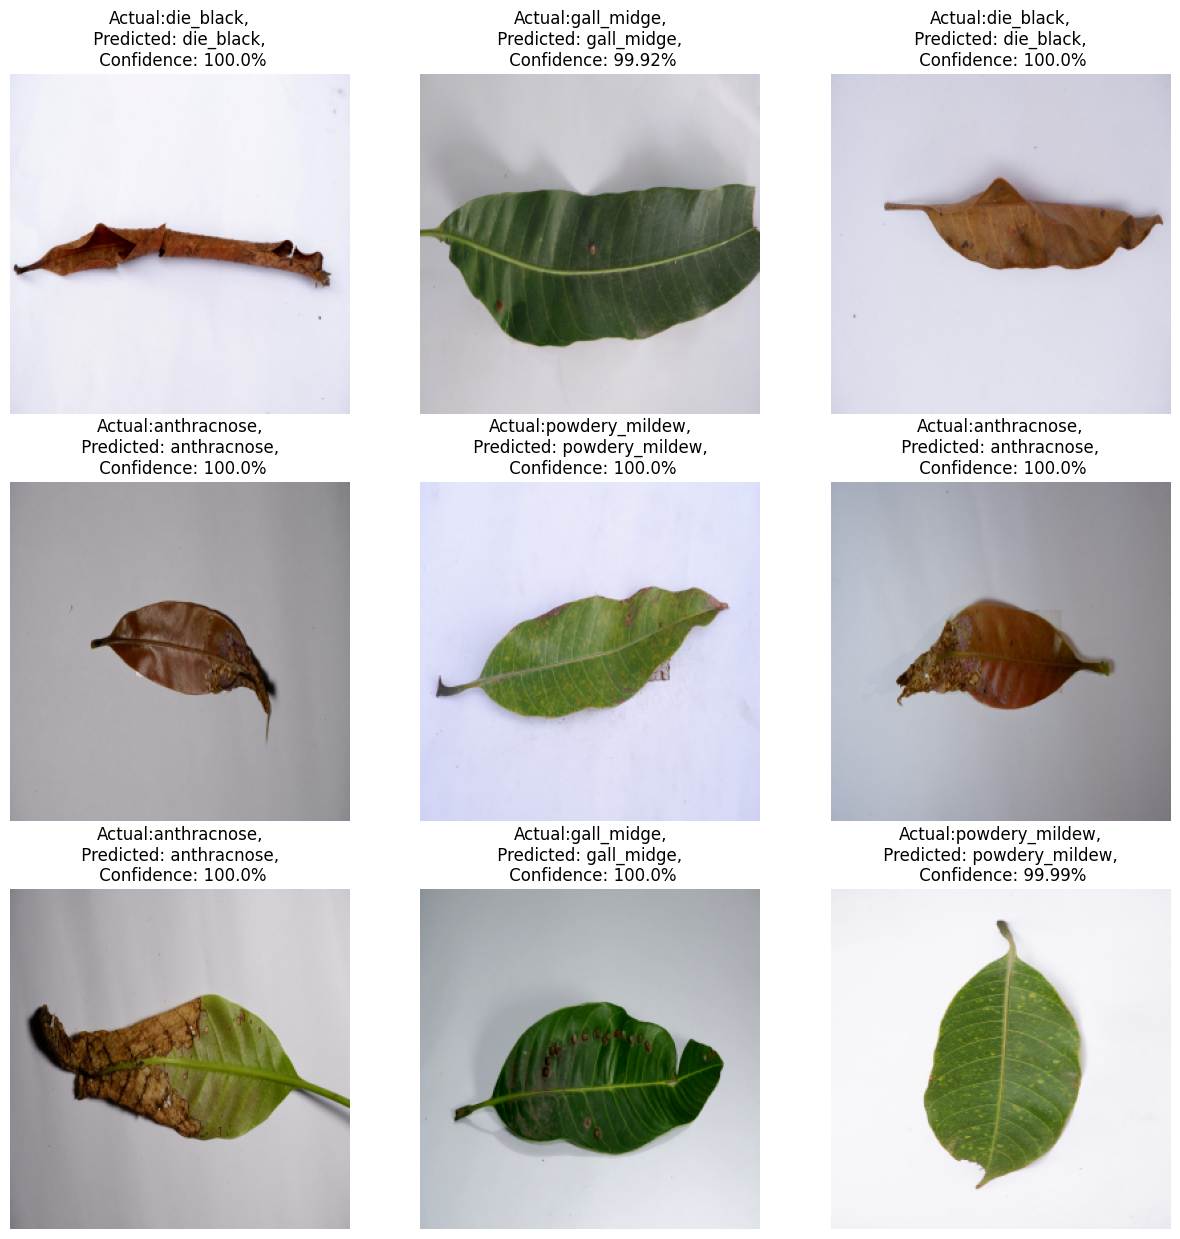

In [28]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [29]:
# To export as a TensorFlow SavedModel (a directory structure, no extension needed)
model_version=8
model.save(f"diseastectionmango/models7/{model_version}")

INFO:tensorflow:Assets written to: diseastectionmango/models7/8\assets


INFO:tensorflow:Assets written to: diseastectionmango/models7/8\assets


In [30]:
model_version = 8
# Append the .keras extension to the filepath
model.save(f"diseastectionmango/models7/{model_version}.keras")
# This will save the model to 'diseastectionpotao/models/1.keras'

In [31]:
model_version = 8
# Append the .h5 extension to the filepath
model.save(f"diseastectionmango/models7/{model_version}.h5")
# This will save the model to 'diseastectionpotao/models/1.h5'